## HW3 Image Classification
#### Solve image classification with convolutional neural networks(CNN).
#### If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

In [1]:
# check GPU type.
!nvidia-smi

Sun Mar 26 05:52:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

### Import Packages

In [2]:
_exp_name = "sample"

In [3]:
# Import necessary packages.
import gc
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [4]:
myseed = 1091102  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Transforms

In [5]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.

image_size = (256,256)
test_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize(image_size),
    transforms.RandomRotation(45),
    transforms.RandomCrop((200,200),padding_mode="edge"),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(1.5, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomPosterize(5, p=0.5),
    transforms.RandomPerspective(distortion_scale=0.15,p=0.5),
#     transforms.ElasticTransform(alpha=10.0),
#     transforms.AugMix(1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5,scale=(0.005,0.005),value=(random.random(),random.random(),random.random())),
    transforms.RandomErasing(p=0.5,scale=(0.005,0.005),value=(random.random(),random.random(),random.random())),
    transforms.RandomErasing(p=0.5,scale=(0.005,0.005),value=(random.random(),random.random(),random.random())),
    transforms.RandomErasing(p=0.5,scale=(0.005,0.005),value=(random.random(),random.random(),random.random())),
])

### Datasets

In [6]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

In [7]:
class FoodDataset_TTA(Dataset):

    def __init__(self,path, train_tfm , test_tfm , TTA_num , files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.train_transform = train_tfm
        self.test_transform = test_tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        train_im = []
        for i in range(TTA_num):
             train_im.append(self.train_transform(im))
            
        test_im = self.test_transform(im)
        
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return train_im,test_im,label

### Model

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
#         self.cnn = models.efficientnet_v2_m()
        self.cnn = models.resnext101_32x8d()
        self.fc = nn.Linear(1000 , 11)
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.fc(out)
        return out

### Configurations

In [9]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
batch_size = 32
n_epochs = 30
patience = 10
criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
TTA_num = 5
TTA_ratio = 0.8
train_valid_ratio = 0.9

read_model = '/kaggle/input/models/sample_best.ckpt'

if read_model != None:
    model.load_state_dict(torch.load(read_model))

### Dataloader

In [10]:
files =  [os.path.join("/kaggle/input/ml2023spring-hw3/train",x) for x in os.listdir("/kaggle/input/ml2023spring-hw3/train") if x.endswith(".jpg")]
files += [os.path.join("/kaggle/input/ml2023spring-hw3/valid",x) for x in os.listdir("/kaggle/input/ml2023spring-hw3/valid") if x.endswith(".jpg")]
label_file = [[] for i in range(11)]
train_file = []
valid_file = []
for file in files:
    label = int(file.split("/")[-1].split("_")[0])
    label_file[label].append(file)
for idx , label in enumerate(label_file):
    random.shuffle(label_file[idx])
    pick_num =  int(len(label) * train_valid_ratio)
    
    for num , file in enumerate(label):
        if num < pick_num:
            train_file.append(file)
        else:
            valid_file.append(file)
train_file.sort()
valid_file.sort()

del files , label_file
gc.collect()

30

In [11]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("/kaggle/input/ml2023spring-hw3/train", tfm=train_tfm , files = train_file)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("/kaggle/input/ml2023spring-hw3/valid", tfm=test_tfm , files = valid_file)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(len(train_set))
print(len(valid_set))

12276
1367


### Start Training

In [12]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
train_acc_record = []
train_loss_record = []
valid_acc_record = []
valid_loss_record = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    train_acc_record.append(train_acc.to('cpu'))
    train_loss_record.append(train_loss)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    valid_acc_record.append(valid_acc.to('cpu'))
    valid_loss_record.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 001/030 ] loss = 0.72419, acc = 0.83750


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 001/030 ] loss = 0.78436, acc = 0.81661
[ Valid | 001/030 ] loss = 0.78436, acc = 0.81661 -> best
Best model found at epoch 0, saving model


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 002/030 ] loss = 0.71203, acc = 0.84753


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 002/030 ] loss = 0.81315, acc = 0.81136
[ Valid | 002/030 ] loss = 0.81315, acc = 0.81136


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 003/030 ] loss = 0.69506, acc = 0.85256


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 003/030 ] loss = 0.73610, acc = 0.83825
[ Valid | 003/030 ] loss = 0.73610, acc = 0.83825 -> best
Best model found at epoch 2, saving model


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 004/030 ] loss = 0.68229, acc = 0.85698


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 004/030 ] loss = 0.76533, acc = 0.83535
[ Valid | 004/030 ] loss = 0.76533, acc = 0.83535


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 005/030 ] loss = 0.68012, acc = 0.85653


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 005/030 ] loss = 0.67140, acc = 0.85977
[ Valid | 005/030 ] loss = 0.67140, acc = 0.85977 -> best
Best model found at epoch 4, saving model


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 006/030 ] loss = 0.67314, acc = 0.86307


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 006/030 ] loss = 0.77797, acc = 0.81310
[ Valid | 006/030 ] loss = 0.77797, acc = 0.81310


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 007/030 ] loss = 0.66789, acc = 0.86276


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 007/030 ] loss = 0.82510, acc = 0.80934
[ Valid | 007/030 ] loss = 0.82510, acc = 0.80934


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 008/030 ] loss = 0.66369, acc = 0.86447


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 008/030 ] loss = 0.84323, acc = 0.79190
[ Valid | 008/030 ] loss = 0.84323, acc = 0.79190


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 009/030 ] loss = 0.65278, acc = 0.86685


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 009/030 ] loss = 0.79880, acc = 0.81705
[ Valid | 009/030 ] loss = 0.79880, acc = 0.81705


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 010/030 ] loss = 0.64021, acc = 0.87261


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 010/030 ] loss = 0.73865, acc = 0.83765
[ Valid | 010/030 ] loss = 0.73865, acc = 0.83765


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 011/030 ] loss = 0.63415, acc = 0.87498


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 011/030 ] loss = 0.80875, acc = 0.81455
[ Valid | 011/030 ] loss = 0.80875, acc = 0.81455


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 012/030 ] loss = 0.62695, acc = 0.87799


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 012/030 ] loss = 0.93970, acc = 0.76412
[ Valid | 012/030 ] loss = 0.93970, acc = 0.76412


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 013/030 ] loss = 0.64811, acc = 0.86672


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 013/030 ] loss = 0.78185, acc = 0.81876
[ Valid | 013/030 ] loss = 0.78185, acc = 0.81876


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 014/030 ] loss = 0.62371, acc = 0.87843


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 014/030 ] loss = 0.82519, acc = 0.81471
[ Valid | 014/030 ] loss = 0.82519, acc = 0.81471


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 015/030 ] loss = 0.61945, acc = 0.88127


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 015/030 ] loss = 1.01479, acc = 0.73929
[ Valid | 015/030 ] loss = 1.01479, acc = 0.73929


  0%|          | 0/384 [00:00<?, ?it/s]

[ Train | 016/030 ] loss = 0.62454, acc = 0.87757


  0%|          | 0/43 [00:00<?, ?it/s]

[ Valid | 016/030 ] loss = 0.73815, acc = 0.84274
[ Valid | 016/030 ] loss = 0.73815, acc = 0.84274
No improvment 10 consecutive epochs, early stopping


[tensor(0.8375), tensor(0.8475), tensor(0.8526), tensor(0.8570), tensor(0.8565), tensor(0.8631), tensor(0.8628), tensor(0.8645), tensor(0.8668), tensor(0.8726), tensor(0.8750), tensor(0.8780), tensor(0.8667), tensor(0.8784), tensor(0.8813), tensor(0.8776)]
[tensor(0.8166), tensor(0.8114), tensor(0.8383), tensor(0.8353), tensor(0.8598), tensor(0.8131), tensor(0.8093), tensor(0.7919), tensor(0.8171), tensor(0.8377), tensor(0.8146), tensor(0.7641), tensor(0.8188), tensor(0.8147), tensor(0.7393), tensor(0.8427)]
[0.7241935175843537, 0.7120310180665305, 0.6950570189704498, 0.6822878066450357, 0.6801176014511535, 0.6731372630068412, 0.6678895535102735, 0.6636925574081639, 0.6527821067720652, 0.6402144237266233, 0.634148264847075, 0.6269487322618564, 0.6481119932141155, 0.6237062981041769, 0.6194534713868052, 0.6245438953240713]
[0.7843573828076207, 0.8131523243216581, 0.7361041141110797, 0.765330569688664, 0.6714012234709984, 0.7779697526332944, 0.8251043114551279, 0.8432338445685631, 0.7987

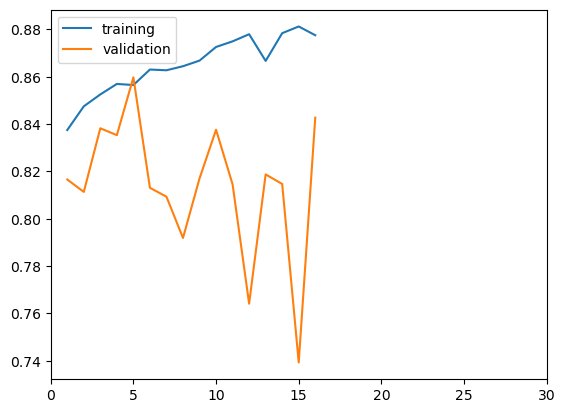

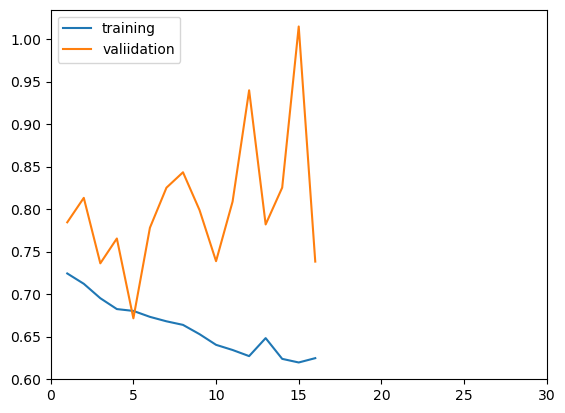

In [13]:
import matplotlib.pyplot as plt
print(train_acc_record)
print(valid_acc_record)
print(train_loss_record)
print(valid_loss_record)


plt.plot([*range(1,len(train_acc_record)+1)] , train_acc_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_acc_record , label = "validation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('acc.png')
plt.show()


plt.plot([*range(1,len(train_acc_record)+1)] , train_loss_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_loss_record , label = "valiidation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('loss.png')
plt.show()

### Dataloader for test

In [14]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset_TTA("/kaggle/input/ml2023spring-hw3/test", train_tfm , test_tfm , TTA_num)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### Testing and generate prediction CSV

In [15]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for train_im , test_im ,_ in tqdm(test_loader):
        pred = model_best(test_im.to(device)) * TTA_ratio
        
        for im in train_im:
            pred += model_best(im.to(device)) *  (1 - TTA_ratio ) / TTA_num
        
        test_label = np.argmax(pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

  0%|          | 0/94 [00:00<?, ?it/s]

In [16]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)